Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, plot_precision_recall_curve, plot_roc_curve

In [3]:
df=pd.read_csv('uber.csv')

In [4]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [5]:
df['dropoff_longitude'].fillna(df['dropoff_longitude'].mean(),inplace=True)
df['dropoff_latitude'].fillna(df['dropoff_latitude'].mean(),inplace=True)

In [6]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)
df.drop(labels='key',axis=1,inplace=True)

In [7]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='dropoff_latitude'>

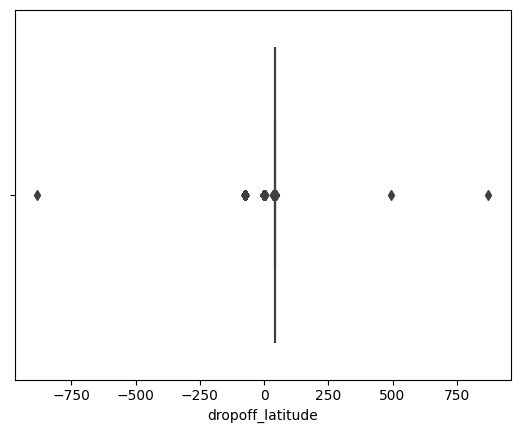

In [9]:
sns.boxplot(df['dropoff_latitude'])

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='fare_amount'>

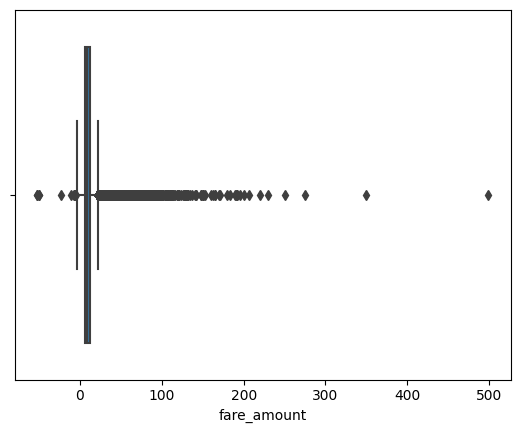

In [10]:
sns.boxplot(df['fare_amount'])

In [11]:
def find_outliers_IQR(df):
   q1 = df.quantile(0.25)
   q3 = df.quantile(0.75)
   IQR = q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [12]:
outliers = find_outliers_IQR(df["fare_amount"])
print("number of outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers.max()))
print("min outlier value: "+ str(outliers.min()))
outliers

number of outliers: 17167
max outlier value: 499.0
min outlier value: -52.0


6         24.50
30        25.70
34        39.50
39        29.00
48        56.80
          ...  
199976    49.70
199977    43.50
199982    57.33
199985    24.00
199997    30.90
Name: fare_amount, Length: 17167, dtype: float64

In [13]:
df=df[(df.pickup_latitude >-90) & (df.pickup_latitude < 90) ]

In [14]:
df.info

<bound method DataFrame.info of         fare_amount          pickup_datetime  pickup_longitude  \
0               7.5  2015-05-07 19:52:06 UTC        -73.999817   
1               7.7  2009-07-17 20:04:56 UTC        -73.994355   
2              12.9  2009-08-24 21:45:00 UTC        -74.005043   
3               5.3  2009-06-26 08:22:21 UTC        -73.976124   
4              16.0  2014-08-28 17:47:00 UTC        -73.925023   
...             ...                      ...               ...   
199995          3.0  2012-10-28 10:49:00 UTC        -73.987042   
199996          7.5  2014-03-14 01:09:00 UTC        -73.984722   
199997         30.9  2009-06-29 00:42:00 UTC        -73.986017   
199998         14.5  2015-05-20 14:56:25 UTC        -73.997124   
199999         14.1  2010-05-15 04:08:00 UTC        -73.984395   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0             40.738354         -73.999512         40.723217                1  
1             4

In [15]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [16]:
def haversine(lat1,lon1,lat2,lon2):
    lat1,lon1,lat2,lon2=map(np.radians,[lat1,lon1,lat2,lon2])
    dlat=lat2-lat1
    dlon=lon2-lon1
    a=np.sin(dlat/2)**2 +np.cos(lat2)*np.sin(dlon/2)**2
    c=2*np.arcsin(np.sqrt(a))
    return 6371 * c
df['distance']=haversine(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'])

In [17]:
df['distance']=haversine(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'])

In [18]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683386
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457648
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.427649
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.739756
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,5.027144


In [19]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683386
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457648
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.427649
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.739756
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,5.027144


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='distance'>

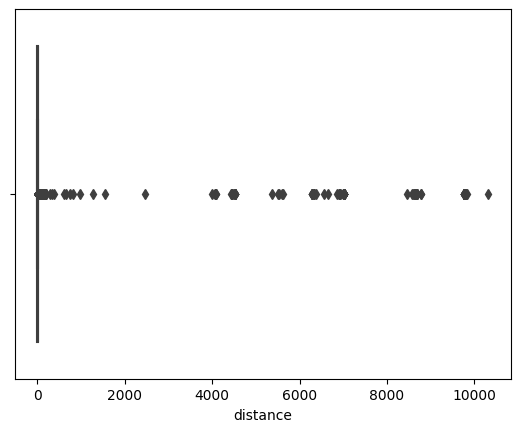

In [20]:
sns.boxplot(df['distance'])

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='distance'>

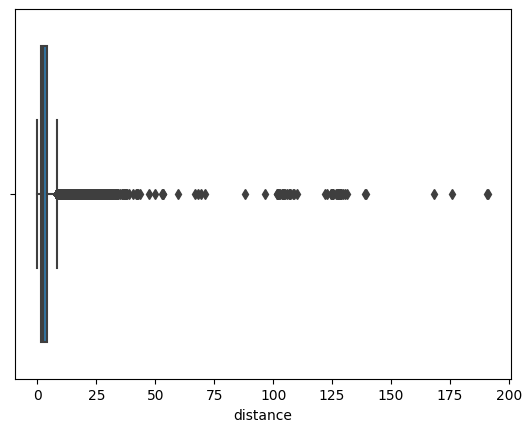

In [21]:
df = df[(df['distance'] > 0) & (df['distance'] < 200)]
sns.boxplot(df['distance'])

In [22]:
df.drop(columns=['pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_14280\3450893677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace=True)



Correlation Matrix:
                 fare_amount  passenger_count  distance
fare_amount         1.000000         0.011889  0.786518
passenger_count     0.011889         1.000000  0.004415
distance            0.786518         0.004415  1.000000


<Axes: xlabel='distance', ylabel='fare_amount'>

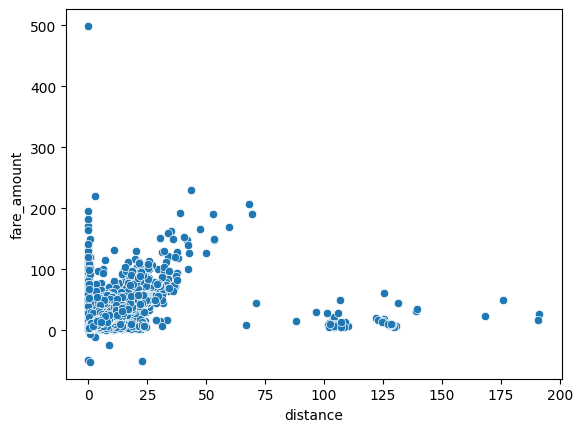

In [23]:
print("\nCorrelation Matrix:")
print(df.corr())

# Visualize the relationship between 'Distance' and 'fare_amount'
sns.scatterplot(x='distance', y='fare_amount', data=df)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [25]:
X = df[['distance']]
y = df['fare_amount']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)


In [26]:
model=LinearRegression()

In [27]:
model.fit(X_train, y_train)

LinearRegression()

In [28]:
y_pred = model.predict(X_test)

In [29]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.6282873399442963


In [30]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(rmse)
print(mae)

5.771025736235249
2.607242769894991


In [31]:
model_r=RandomForestRegressor(n_estimators=100, random_state=42)

In [32]:
model_r.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [33]:
y_pred_3 = model_r.predict(X_test)

In [34]:
r_squared = r2_score(y_test, y_pred_3)
print(r_squared)

0.6695570209633184


In [35]:
rmse = mean_squared_error(y_test, y_pred_3, squared=False)
mae = mean_absolute_error(y_test, y_pred_3)
print(rmse)
print(mae)

5.441236454697371
2.7619836880028608
